In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import seaborn as sns
# Set the default color cycle
import pandas as pd
import matplotlib as mpl

from scipy.stats import linregress
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

fontsize=14

In [2]:
def create_scatter(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)


    CMIP6_label = "CMIP6"
    
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"r={r}"
        plt.scatter(x5, y5, s=100, alpha=.5, edgecolor="black", color=colors[1], label=CMIP5_label)
        # plt.scatter(np.mean(x5), np.mean(y5), edgecolor="black", s=200, zorder=100, color=colors[1], marker="x")
        plt.plot(np.array(sorted(x6)), np.array(sorted(x6))*slope+intercept, color=colors[1], alpha=.5)

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        plt.plot(np.array(sorted(x6)), np.array(sorted(x6))*slope+intercept, color=colors[0], alpha=.5)
        CMIP6_label = f"r={r}"
    
    plt.scatter(x6, y6, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP6_label)
    # plt.scatter(np.mean(x6), np.mean(y6), s=200, zorder=100, edgecolor="black", color=colors[0], marker="x")

    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.grid()
    if len(vline) != 0:
        plt.vlines(vline, ymin=-1.0, ymax=2.5, color="navy", linestyle="dashed", alpha=.5)

    plt.vlines(np.mean(vline), ymin=-1.0, ymax=2.5, color="navy")

    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    plt.plot(np.array(sorted(x)), np.array(sorted(x))*slope+intercept, color="black")
    plt.legend(loc="upper left", fontsize=fontsize)
    
    # plt.title(left_title, loc="left", fontweight="bold")
    plt.title(f"{right_title} r={r}", loc="right", fontweight="bold", fontsize=fontsize)
    plt.title("A", fontweight="bold", loc="left", fontsize=fontsize)
    
    fig = plt.gcf()
    fig.set_size_inches(6, 6)

    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))
    plt.xlim(xmin-borderx, xmax+borderx)
    plt.ylim(ymin-bordery, ymax+bordery)
    
    # Vertical Lines for Ensemble Means
    plt.vlines(np.mean(x5), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[1], linestyle="--", label='_nolegend_', alpha=.5, zorder=0) 
    plt.vlines(np.mean(x6), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], linestyle="--", label='_nolegend_', alpha=.5, zorder=0) 



def create_scatter_hists(x6, y6, x5: list = [], y5: list = [], vline=0, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None: 
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    # Create Pandas DataFrame from lists
    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    cmip6 = pd.DataFrame([x6, y6], index=["X", "Y"])
    cmip5 = pd.DataFrame([x5, y5], index=["X", "Y"])
    labels6 = pd.DataFrame([["CMIP6" for i in range(len(x6))]], index=["Ensemble"])
    labels5 = pd.DataFrame([["CMIP5" for i in range(len(x5))]], index=["Ensemble"])
    fbs = cmip6.T.append(cmip5.T, ignore_index=True)
    ens = labels6.T.append(labels5.T, ignore_index=True)
    df = pd.concat([fbs, ens], axis=1)

    # Create JointGrid object using Seaborn containing histogram and scatterplot
    g = sns.JointGrid(data=df, x="X", y="Y", hue="Ensemble")
    g.plot_marginals(sns.kdeplot, fill=True, alpha=.5, legend=False)
    g.plot_joint(sns.scatterplot, s=100, alpha=.5, edgecolor="black", legend=False)

    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))

    g.ax_joint.vlines(vline, ymin=ymin-bordery, ymax=ymax+bordery, color="navy", linestyle="--", label='_nolegend_', alpha=.75) # COBE

    # Vertical Lines for Ensemble Means
    g.ax_joint.vlines(np.mean(x5), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[1], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    g.ax_joint.vlines(np.mean(x6), ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], linestyle="--", label='_nolegend_', alpha=.75, zorder=0) # COBE
    
    # Add Letter title
    fig = plt.gcf()
    plt.text(0.05, .9, left_title, fontsize = 16, transform=fig.transFigure, fontweight="bold", zorder=.1)
    # Plot Regression Line for Combined Ensemble
    x, y  = zip(*sorted(zip(x, y)))
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color="black", linestyle="--", label='_nolegend_')
    g.ax_joint.grid()
    plt.text(.15, .75, f'r={r}', fontsize = 12, bbox = dict(edgecolor='white', facecolor = 'white', alpha = 0.5), transform=fig.transFigure, label='_nolegend_')

    # Add Regression Line for CMIP5 and CMIP6
    if len(x5) != 0: 
        slope, intercept, r5, p5, _ = linregress(x5,y5)
        r5, p5 = np.around(r5, 3), np.around(p5, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[1], linestyle="solid")


        slope, intercept, r6, p6, _ = linregress(x6,y6)
        r6, p6 = np.around(r6, 3), np.around(p6, 3)
        g.ax_joint.plot(np.array(x), np.array(x)*slope+intercept, color=colors[0], linestyle="solid")

    # Clean up x and y limits and labels
    g.ax_joint.set_xlim(xmin-borderx, xmax+borderx)
    g.ax_joint.set_ylim(ymin-bordery, ymax+bordery)
    g.ax_joint.set_xlabel(xlabel)
    g.ax_joint.set_ylabel(ylabel)
    # plt.grid()
    plt.legend(labels=[f"CMIP5 r={r5}", f"CMIP6 r={r6}", "Obs"], bbox_to_anchor=(1,0), loc="lower right",  bbox_transform=fig.transFigure)

In [3]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)
    
# TOA SWCF
swcf_cmip6, sst_ept_cmip6 = get_shared_models(xr.open_dataarray("data/piControl/swcf_east_sa_cmip6_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc"))
swcf_cmip5, sst_ept_cmip5 = get_shared_models(xr.open_dataarray("data/piControl/swcf_east_sa_cmip5_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc"))

# Surface SWCF
# swcf_cmip6, sst_ept_cmip6 = get_shared_models(xr.open_dataarray("data/piControl/cf_east_sa_swcf-surface_cmip6_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc"))
# swcf_cmip5, sst_ept_cmip5 = get_shared_models(xr.open_dataarray("data/piControl/cf_east_sa_swcf-surface_cmip5_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc"))

# Surface LWCF
# swcf_cmip6, sst_ept_cmip6 = get_shared_models(xr.open_dataarray("data/piControl/cf_east_sa_lwcf-surface_cmip6_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc"))
# swcf_cmip5, sst_ept_cmip5 = get_shared_models(xr.open_dataarray("data/piControl/cf_east_sa_lwcf-surface_cmip5_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc"))

# Surface NET
# swcf_cmip6, sst_ept_cmip6 = get_shared_models(xr.open_dataarray("data/piControl/cf_east_sa_net-surface_cmip6_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc"))
# swcf_cmip5, sst_ept_cmip5 = get_shared_models(xr.open_dataarray("data/piControl/cf_east_sa_net-surface_cmip5_v3.nc"), xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc"))

In [ ]:
swcf_cmip5.values

array([ 3.37147567e+00,  3.54025746e+00,  2.46498996e+00,  3.20096236e+00,
        1.07182388e+00,  5.98716446e+00,  2.82197448e+00,  8.53505786e-01,
        2.80977978e+00,  6.34289649e-02,  5.94389088e+00,  2.64850110e+00,
        5.37468002e+00,  4.31061179e+00,  2.83188448e+00,  4.48418076e+00,
        3.74906050e+00, -3.21177861e-03,  7.54182232e+00,  4.40499251e+00,
        1.80880478e+00,  9.99701726e-01,  2.10216271e+00,  2.28165619e+00,
        5.41121145e+00,  4.28500268e+00,  2.45875151e+00,  2.81857497e+00,
        6.60472503e+00, -8.52489100e-01,  2.84612604e+00,  4.68455546e+00,
        1.86918931e+00])

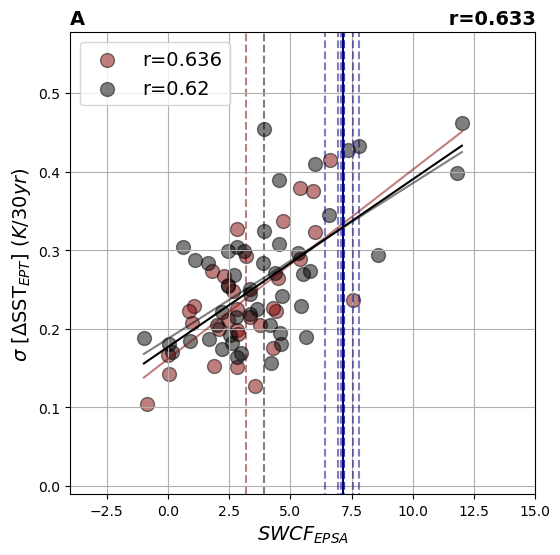

In [5]:
create_scatter(
    swcf_cmip6.values, 
    sst_ept_cmip6.std("time").values, 
    swcf_cmip5.values, 
    sst_ept_cmip5.std("time").values, 
    vline=[7.81434168, 7.17606042, 7.57042384, 6.95852917, 7.05380873, 6.41551741, 7.17404065], 
    left_title="A", 
    xlabel=r"$SWCF_{EPSA}$", 
    ylabel=r"$\sigma$ [$\Delta $SST$_{EPT}$] ($K/30yr$)"
)

In [18]:
import scipy.stats as stats
import random

mean = 0
# obs_sst_trends_old = [-0.30995762, -0.30437485, -0.24953692, -0.26466877, -0.30762401, -0.13590471, -0.24306433] 
obs_sst_trends = [-0.30252565, -0.248169, -0.26244152, -0.14976065, -0.13896384]
threshold = np.mean(obs_sst_trends)
thresholds = obs_sst_trends

# obs_swcf = [8.36540737, 7.82886862, 8.00645314, 7.33647818, 7.52747689, 6.92114465, 7.82383226] # Surface
# obs_swcf = [7.41950586, 6.87259636, 7.10078097, 6.54876154, 6.65187705, 6.13171316, 6.87224081] # New TOA
obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
print(np.mean(obs_swcf))
# obs_swcf = [7.81434168, 7.17606042, 7.57042384, 6.95852917, 7.05380873, 6.41551741, 7.17404065] # Old TOA
sample_size = 40

swcf = xr.concat([swcf_cmip6, swcf_cmip5], dim="model")
sst_ept = xr.concat([sst_ept_cmip6, sst_ept_cmip5], dim="model")

mu = np.mean(thresholds)
sigma = np.std(thresholds)

# Bootstrap
niters = 10000
p_obs, p_model, p_diff = [], [], []
for iter in range(niters): 
    # all_numbers = list(range(0, len(swcf.model.values)))
    # # Shuffle the list to achieve randomness
    # random.shuffle(all_numbers)
    # # Select the first n elements from the shuffled list
    # random_models = all_numbers[:sample_size]

    n = len(swcf.model.values)
    random_models = np.random.choice(n, size=n, replace=True) 

    swcf_sub = swcf.isel(model=random_models)
    sst_ept_sub = sst_ept.isel(model=random_models)
    reg = linregress(swcf_sub.values, sst_ept_sub.std("time").values)

    estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
    obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)

    # Randomly choose value from thresholds
    # threshold = random.choice(thresholds) # Option 1: Choose specific threshold value
    threshold = random.gauss(mu, sigma) # Option 2: Choose threshold from normal distribution defined by obs
    p_obs.append(obs_normal_dist.cdf(threshold))
    
    multimodel_mean_variance = sst_ept_sub.std("time").mean("model")
    
    # Create a normal distribution with the specified mean and variance
    model_normal_dist = stats.norm(loc=mean, scale=multimodel_mean_variance)

    p_model.append(model_normal_dist.cdf(threshold))
    p_diff.append(obs_normal_dist.cdf(threshold) - model_normal_dist.cdf(threshold))

p_obs = np.array(p_obs)*100
p_model = np.array(p_model)*100
p_diff = np.array(p_diff)*100

6.774003174000001


In [5]:
x = np.linspace(-1., 1., 100)
reg = linregress(swcf.values, sst_ept.std("time").values)
estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)

In [6]:
# raw_normal_dist = stats.norm(loc=mean, scale=np.std(sst_ept.values.flatten()))
# sns.histplot(sst_ept.values.flatten(), stat="density")
# plt.plot(x, raw_normal_dist.pdf(x), label="obs")
# plt.xlabel(r"$SST_{EPT}$ Trend ($K/30yr$)")
# plt.grid()

Text(0.0, 1.0, 'B')

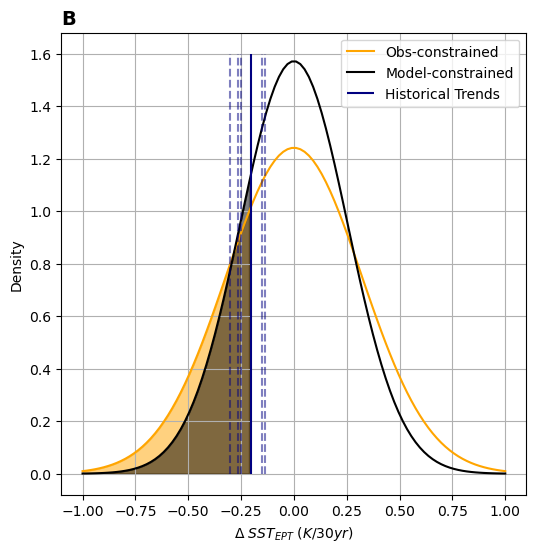

In [7]:
x = np.linspace(-1., 1., 100)
reg = linregress(swcf.values, sst_ept.std("time").values)
estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)
model_normal_dist = stats.norm(loc=mean, scale=sst_ept.std("time").mean("model"))

plt.plot(x, obs_normal_dist.pdf(x), label="Obs-constrained", color="orange")
plt.plot(x, model_normal_dist.pdf(x), label="Model-constrained", color="black")

# Fill area under the curve
# Get x values less than threshold
x_fill = x[x <= threshold]
plt.fill_between(x_fill, obs_normal_dist.pdf(x_fill), color="orange", alpha=.5)
plt.fill_between(x_fill, model_normal_dist.pdf(x_fill), color="black", alpha=.5)

plt.vlines([threshold], ymin=0, ymax=1.6, color="navy", label="Historical Trends")  # Replace t with your desired threshold
plt.vlines(thresholds, ymin=0, ymax=1.6, color="navy", linestyle="dashed", alpha=.5)  # Replace t with your desired threshold
plt.xlabel(r"$\Delta$ $SST_{EPT}$ ($K/30yr$)")
plt.ylabel("Density")
plt.legend()
plt.grid()
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title("B", fontweight="bold", loc="left", fontsize=fontsize)
# sns.histplot()
# sns.histplot(p_model)

In [8]:
# plt.plot(x, obs_normal_dist.cdf(x), label="obs")
# plt.plot(x, model_normal_dist.cdf(x), label="model")
# plt.vlines([threshold], ymin=0, ymax=1.6, color="navy", label="Hist")  # Replace t with your desired threshold
# plt.legend()
# plt.xlabel(r"$SST_{EPT}$ Trend ($K/30yr$)")
# plt.ylabel(r"Cumulative Probability")
# plt.title("B", fontweight="bold", loc="left")
# fig = plt.gcf()
# fig.set_size_inches(6, 6)

# plt.grid()

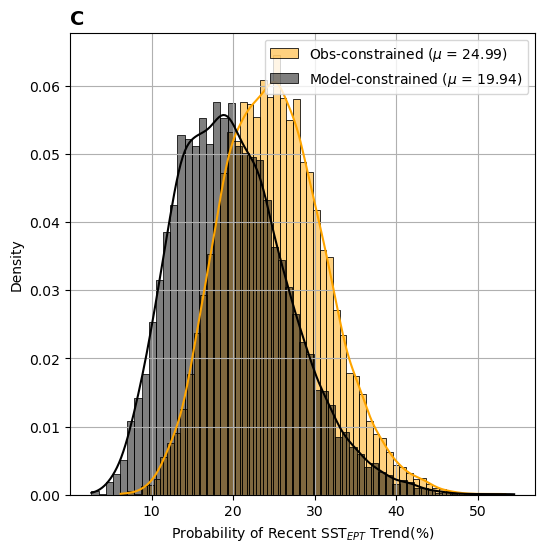

In [9]:

obs_mu = np.around(np.nanmean(p_obs), 2)
model_mu = np.around(np.nanmean(p_model), 2)
diff_mu = np.around(np.nanmean(p_diff), 2)
sns.histplot(p_obs, label=f"Obs-constrained ($\mu$ = {obs_mu})", kde=True, color="orange", stat='density')
sns.histplot(p_model, label=f"Model-constrained ($\mu$ = {model_mu})", kde=True, color="black", stat='density')
plt.legend()
plt.grid()
plt.xlabel("Probability of Recent SST$_{EPT}$ Trend(%)")
plt.title("C", fontweight="bold", loc="left", fontsize=fontsize)
plt.ylabel("Density")
fig = plt.gcf()
fig.set_size_inches(6, 6)

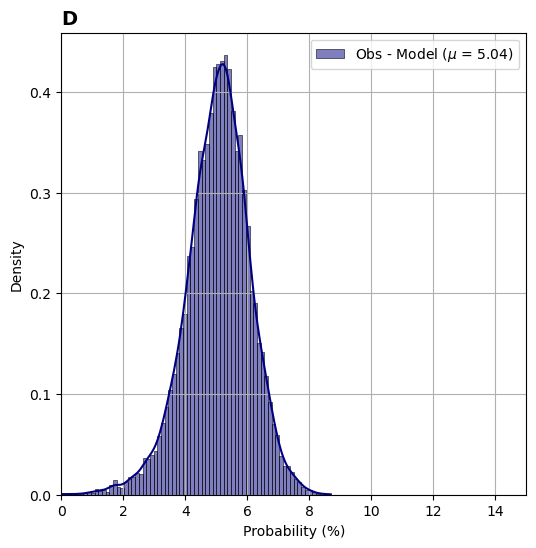

In [10]:
sns.histplot(p_diff, label=f"Obs - Model ($\mu$ = {diff_mu})", kde=True, color="navy", stat="density") # color='#7570b3')
plt.xlim(0, 15)
plt.legend()
plt.grid()
plt.xlabel("Probability (%)")
plt.title("D", fontweight="bold", loc="left", fontsize=fontsize)
fig = plt.gcf()
fig.set_size_inches(6, 6)


In [11]:
def create_panel_a(ax, x6, y6, x5: list = [], y5: list = [], vline=0) -> None:
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    CMIP6_label = "CMIP6"
    
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"r={r}"
        ax.scatter(x5, y5, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP5_label)

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP6_label = f"r={r}"
    
    ax.scatter(x6, y6, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP6_label)

    # Vertical line for avg and std of obs
    ax.vlines(np.mean(vline), ymin=-1.0, ymax=2.5, color="navy")
    ax.fill_between(x=[np.mean(vline) - np.std(vline), np.mean(vline) + np.std(vline)], y1=-1, y2=2.5, color="navy", alpha=.25)

    # Multimodel mean
    mmm = np.mean([*x5, *x6])


    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))

    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    if p < .05: 
        sig = '*'
    else: 
        sig = ''
    print(r, p)

    x = np.array(sorted(x))
    ax.plot(x, x*slope+intercept, color="black")
    # ax.legend(loc="upper left", fontsize=fontsize)
    ax.set_title(f"r={r}{sig}", loc="right", fontweight="bold", fontsize=16)
    
    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))
    ax.set_xlim(xmin-borderx, xmax+borderx)
    ax.set_ylim(ymin-bordery, ymax+bordery)


    # Add Model Vertical Lines
    ax.vlines(mmm, ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], label='_nolegend_', alpha=.5, linewidth=2, zorder=0) 
    ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=-1, y2=2.5, color="black", alpha=.25)

    # Add horizontal sigma lines
    sig_mmm = mmm*slope+intercept
    sig_obs = np.mean(vline)*slope+intercept
    hline_width = 3
    ax.hlines(y=sig_mmm, xmin=xmin-borderx, xmax=mmm, color="black", linewidth=hline_width)
    ax.hlines(y=sig_obs, xmin=xmin-borderx, xmax=np.mean(vline), color="orange", linewidth=hline_width)

    ax.text(s=r"$\sigma$" + f"({np.around(sig_mmm, 3)})", x=xmin-borderx*.95, y=sig_mmm + sig_mmm*.025, color="black", fontsize=12, fontweight="bold")
    ax.text(s=r"$\sigma$" + f"({np.around(sig_obs, 3)})", x=xmin-borderx*.95, y=sig_obs + sig_mmm*.025, color="orange", fontsize=12, fontweight="bold")

    return sig_mmm, sig_obs
    

In [12]:
def create_panel_b(ax, sig_obs, sig_mmm):
    x = np.linspace(-1., 1., 100)
    reg = linregress(swcf.values, sst_ept.std("time").values)
    print(reg)
    estimated_obs_variance = reg.slope*np.mean(obs_swcf) + reg.intercept
    obs_normal_dist = stats.norm(loc=mean, scale=estimated_obs_variance)
    model_normal_dist = stats.norm(loc=mean, scale=sst_ept.std("time").mean("model"))

    ax.plot(x, obs_normal_dist.pdf(x), label="Obs-constrained", color="orange")
    ax.plot(x, model_normal_dist.pdf(x), label="Model-constrained", color="black")

    # Fill area under the curve
    x_fill = x[x <= threshold]
    ax.fill_between(x_fill, obs_normal_dist.pdf(x_fill), color="orange", alpha=.5)
    ax.fill_between(x_fill, model_normal_dist.pdf(x_fill), color="black", alpha=.5)

    # Add Vertical Lines for SST Trends
    ax.vlines([np.mean(thresholds)], ymin=0, ymax=1.7, color="navy", label="Historical Trends")  # Replace t with your desired threshold
    ax.fill_between(x=[np.mean(thresholds) - np.std(thresholds), np.mean(thresholds) + np.std(thresholds)], y1=0, y2=1.7, color="navy", alpha=.25)
    
    # Obs PDF
    y_std = obs_normal_dist.pdf(-sig_obs)
    ax.arrow(x=-sig_obs, y=y_std, dx=sig_obs*2, dy=0 ,color="orange", linewidth=3, head_width=.03, length_includes_head=True, zorder=3)
    ax.arrow(x=+sig_obs, y=y_std, dx=-sig_obs*2, dy=0 ,color="orange", linewidth=3, head_width=.03, length_includes_head=True, zorder=3)
    ax.text(s=r"$\sigma$" + f"({np.around(sig_obs, 3)})", x=0, y=y_std, color="orange", fontsize=12, fontweight="bold", verticalalignment="bottom", horizontalalignment="center")
    
    # Multimodel mean PDF
    y_std = obs_normal_dist.pdf(-sig_mmm)
    ax.arrow(x=-sig_mmm, y=y_std, dx=sig_mmm*2, dy=0 ,color="black", linewidth=3, head_width=.03, length_includes_head=True, zorder=3)
    ax.arrow(x=+sig_mmm, y=y_std, dx=-sig_mmm*2, dy=0 ,color="black", linewidth=3, head_width=.03, length_includes_head=True, zorder=3)
    ax.text(s=r"$\sigma$" + f"({np.around(sig_mmm, 3)})", x=0, y=y_std, color="black", fontsize=12, fontweight="bold", verticalalignment="bottom", horizontalalignment="center")

    ax.legend()

In [13]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def _global_plot(ax, data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="max",
        levels=levels,
    )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # East Pacific South America
    bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -65, 65
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )



## Fig 2 without Map

0.633 0.0
LinregressResult(slope=0.021340897560718695, intercept=0.17672642046661266, rvalue=0.6325885080272122, pvalue=2.3718723323584034e-10, stderr=0.002939629338383629, intercept_stderr=0.012691601652893415)


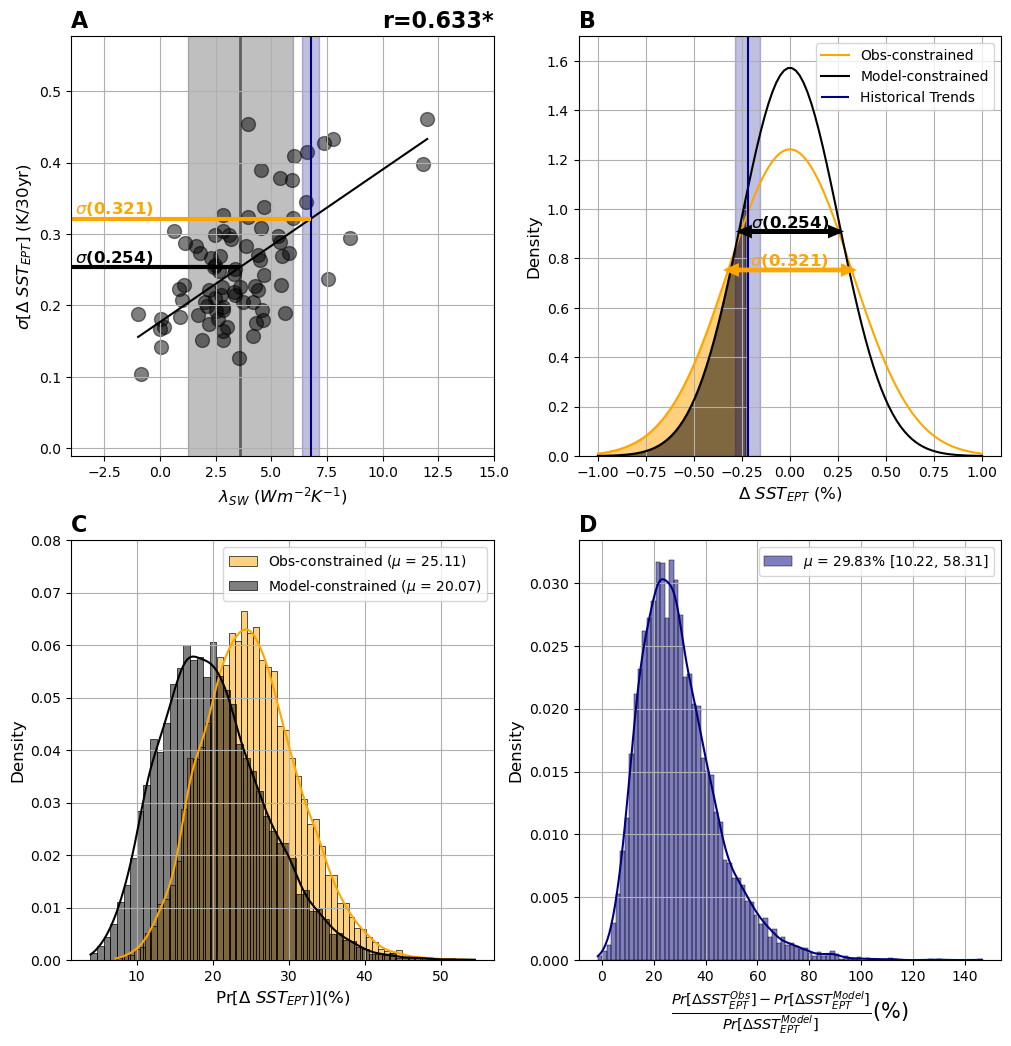

In [16]:
def create_figure_2(
    p_obs: np.ndarray, # Plot C
    p_model: np.ndarray, # Plot C
    p_diff: np.ndarray # Plot D
):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    axis_fontsize = 12
    title_fontsize = 16
    
    # SWCF vs Variance of Trends 
    ax[0][0].grid()
    # ax[0][0].set_xlabel(r"SWCF$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[0][0].set_xlabel(r"$\lambda_{SW}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[0][0].set_ylabel(r"$\sigma$[$\Delta$ $SST_{EPT}$] (K/30yr)", fontsize=axis_fontsize) 
    ax[0][0].set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
    sig_mmm, sig_obs = create_panel_a(
        ax[0][0],
        swcf_cmip6.values, 
        sst_ept_cmip6.std("time").values, 
        swcf_cmip5.values, 
        sst_ept_cmip5.std("time").values, 
        vline=obs_swcf #[7.81434168, 7.17606042, 7.57042384, 6.95852917, 7.05380873, 6.41551741, 7.17404065], 
    )

    # PDF of Obs and Model
    ax[0][1].grid()
    ax[0][1].set_xlabel(r"$\Delta$ $SST_{EPT}$ (%)", fontsize=axis_fontsize)
    ax[0][1].set_ylabel("Density", fontsize=axis_fontsize) 
    ax[0][1].set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax[0][1].set_ylim(0, 1.7)
    create_panel_b(ax=ax[0][1], sig_mmm=sig_mmm, sig_obs=sig_obs)
    
    # CDF of Obs and Model at Threshold
    ax[1][0].grid()
    ax[1][0].set_xlabel(r"Pr[$\Delta$ $SST_{EPT}$)](%)", fontsize=axis_fontsize)
    ax[1][0].set_ylabel("Density", fontsize=axis_fontsize) 
    ax[1][0].set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)
    sns.histplot(p_obs, label=f"Obs-constrained ($\mu$ = {obs_mu})", kde=True, color="orange", stat='density', ax=ax[1][0])
    sns.histplot(p_model, label=f"Model-constrained ($\mu$ = {model_mu})", kde=True, color="black", stat='density', ax=ax[1][0])
    ax[1][0].set_ylim(0, .08)
    ax[1][0].legend()

    # Plot Diff between Obs and Model CDFs
    p_diff = (p_obs/p_model - 1)*100
    lower_thres = np.around(np.quantile(p_diff, .05), 2)
    upper_thres = np.around(np.quantile(p_diff, .95), 2)
    diff_mu = np.around(np.nanmean(p_diff), 2)

    # sns.histplot(p_diff, label=f"Obs - Model ($\mu$ = {diff_mu}%) [{lower_thres}, {upper_thres}]", kde=True, color="navy", stat="density", ax=ax[1][1]) 
    sns.histplot(p_diff, label=f"$\mu$ = {diff_mu}% [{lower_thres}, {upper_thres}]", kde=True, color="navy", stat="density", ax=ax[1][1]) 
    ax[1][1].grid()
    # ax[1][1].set_ylim(0, .55)
    # ax[1][1].set_xlabel(r"Pr[$\Delta$ $SST_{EPT}^{Obs}$ - $\Delta$ $SST_{EPT}^{Model}$)](%)", fontsize=axis_fontsize)
    ax[1][1].set_xlabel(r"$\frac{ Pr[\Delta SST_{EPT}^{Obs}] - Pr[\Delta SST_{EPT}^{Model}]}{Pr[\Delta SST_{EPT}^{Model}]}$(%)", fontsize=axis_fontsize*1.25)
    ax[1][1].set_ylabel("Density", fontsize=axis_fontsize) 
    ax[1][1].set_title("D", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax[1][1].legend()

    plt.savefig("Figure_2_updated.png", dpi=600, bbox_inches="tight")
    plt.show()


# Plot C
obs_mu = np.around(np.nanmean(p_obs), 2)
model_mu = np.around(np.nanmean(p_model), 2)
diff_mu = np.around(np.nanmean(p_diff), 2)

create_figure_2(
    p_obs=p_obs,
    p_model=p_model,
    p_diff=p_diff
)

## Fig 2 with Map

In [16]:
def make_cyclic(ds):
    ds_end = ds.isel(lon=-1)
    ds_end["lon"] = 180
    ds_beg = ds.isel(lon=0)
    ds_beg["lon"] = -180
    ds_beg
    ds = xr.concat([ds_beg, ds, ds_end], dim="lon")
    return ds

def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

swcf_cmip6_r2 = xr.open_dataset('data/piControl/swcf_cmip6_monthly_1850-2000.nc')
swcf_cmip5_r2 = xr.open_dataset('data/piControl/swcf_cmip5_monthly_1850-2000.nc')
ept6_r2 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc")
ept5_r2 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc")

ept_r2 = xr.concat([ept6_r2, ept5_r2], dim="model")
swcf_cmip_r2 = xr.concat([swcf_cmip6_r2, swcf_cmip5_r2], dim="model")

swcf_cmip_r2, ept_r2 = get_shared_models(swcf_cmip_r2, ept_r2)

r = xscore.pearson_r(swcf_cmip_r2["swcf"], ept_r2.std('time'), dim='model', skipna=True)
p = xscore.pearson_r_p_value(swcf_cmip_r2["swcf"], ept_r2.std('time'), dim='model', skipna=True)
r2 = r**2

r2 = make_cyclic(r2)
p = make_cyclic(p)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:351: RuntimeWarning: invalid value encountered in divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:352: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)


0.633 0.0
LinregressResult(slope=0.021340897560718688, intercept=0.1767264204666127, rvalue=0.6325885080272119, pvalue=2.371872332358472e-10, stderr=0.0029396293383836306, intercept_stderr=0.01269160165289342)


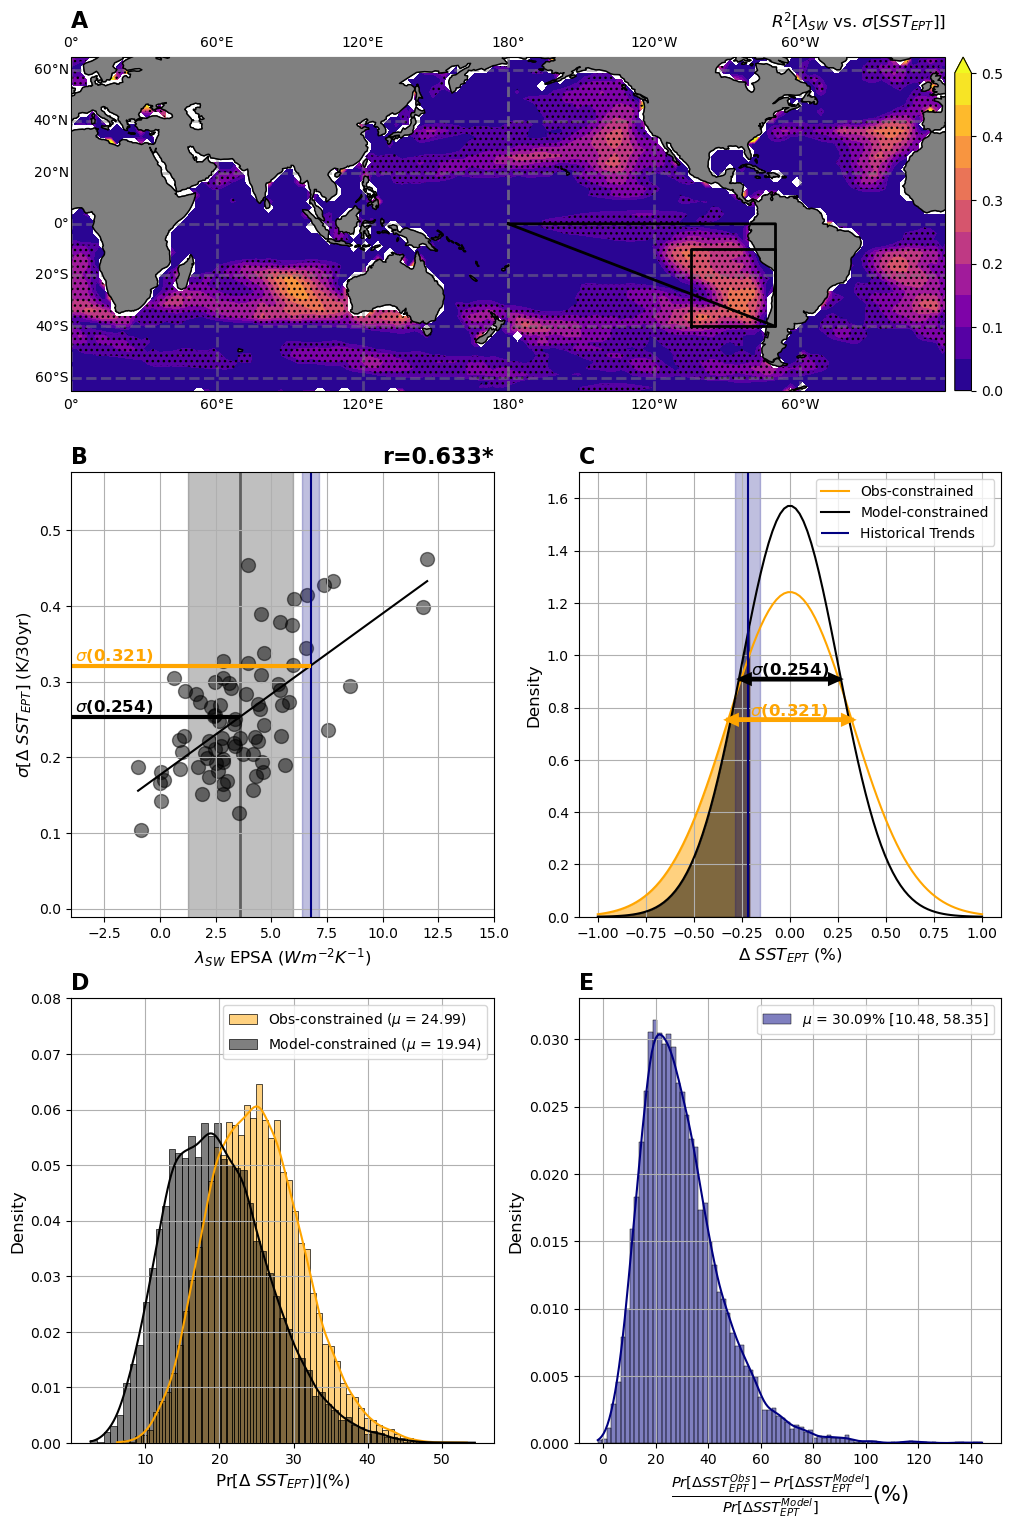

In [17]:
def create_figure_2(
    p_obs: np.ndarray, # Plot C
    p_model: np.ndarray, # Plot C
    p_diff: np.ndarray # Plot D
):
    fig = plt.figure(figsize=(12, 18))
    gs = fig.add_gridspec(3, 2, height_ratios=[1.5,2,2])
    ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)
    ax2 = fig.add_subplot(gs[1, 0]) # A
    ax3 = fig.add_subplot(gs[1, 1]) # B
    ax4 = fig.add_subplot(gs[2, 0]) # C
    ax5 = fig.add_subplot(gs[2, 1]) # D
    ax = [[ax2, ax3], [ax4, ax5], [ax1, ax1]]

    # fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    axis_fontsize = 12
    title_fontsize = 16
    
    # Plot spatial map
    img = _global_plot(
        ax1,
        data=r2,
        pvalues=p,
        lat=r2.lat,
        lon=r2.lon,
        levels=np.arange(0, .55, .05),
        cmap="plasma",
        cbar_label="K/30yr"
    )
    ax1.set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax1.set_title(r"$R^2[\lambda_{SW}$ vs. $\sigma[SST_{EPT}]]$", loc="right", fontsize=title_fontsize*.75)
    cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.05, pad=.01, aspect=20) 
    ax1.set_aspect('auto', adjustable=None)
    
    # SWCF vs Variance of Trends 
    ax[0][0].grid()
    # ax[0][0].set_xlabel(r"SWCF$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[0][0].set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[0][0].set_ylabel(r"$\sigma$[$\Delta$ $SST_{EPT}$] (K/30yr)", fontsize=axis_fontsize) 
    ax[0][0].set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
    sig_mmm, sig_obs = create_panel_a(
        ax[0][0],
        swcf_cmip6.values, 
        sst_ept_cmip6.std("time").values, 
        swcf_cmip5.values, 
        sst_ept_cmip5.std("time").values, 
        vline=obs_swcf #[7.81434168, 7.17606042, 7.57042384, 6.95852917, 7.05380873, 6.41551741, 7.17404065], 
    )

    # PDF of Obs and Model
    ax[0][1].grid()
    ax[0][1].set_xlabel(r"$\Delta$ $SST_{EPT}$ (%)", fontsize=axis_fontsize)
    ax[0][1].set_ylabel("Density", fontsize=axis_fontsize) 
    ax[0][1].set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax[0][1].set_ylim(0, 1.7)
    create_panel_b(ax=ax[0][1], sig_mmm=sig_mmm, sig_obs=sig_obs)
    
    # CDF of Obs and Model at Threshold
    ax[1][0].grid()
    ax[1][0].set_xlabel(r"Pr[$\Delta$ $SST_{EPT}$)](%)", fontsize=axis_fontsize)
    ax[1][0].set_ylabel("Density", fontsize=axis_fontsize) 
    ax[1][0].set_title("D", loc="left", fontweight="bold", fontsize=title_fontsize)
    sns.histplot(p_obs, label=f"Obs-constrained ($\mu$ = {obs_mu})", kde=True, color="orange", stat='density', ax=ax[1][0])
    sns.histplot(p_model, label=f"Model-constrained ($\mu$ = {model_mu})", kde=True, color="black", stat='density', ax=ax[1][0])
    ax[1][0].set_ylim(0, .08)
    ax[1][0].legend()

    # Plot Diff between Obs and Model CDFs
    p_diff = (p_obs/p_model - 1)*100
    lower_thres = np.around(np.quantile(p_diff, .05), 2)
    upper_thres = np.around(np.quantile(p_diff, .95), 2)
    diff_mu = np.around(np.nanmean(p_diff), 2)

    # sns.histplot(p_diff, label=f"Obs - Model ($\mu$ = {diff_mu}%) [{lower_thres}, {upper_thres}]", kde=True, color="navy", stat="density", ax=ax[1][1]) 
    sns.histplot(p_diff, label=f"$\mu$ = {diff_mu}% [{lower_thres}, {upper_thres}]", kde=True, color="navy", stat="density", ax=ax[1][1]) 
    ax[1][1].grid()
    # ax[1][1].set_ylim(0, .55)
    # ax[1][1].set_xlabel(r"Pr[$\Delta$ $SST_{EPT}^{Obs}$ - $\Delta$ $SST_{EPT}^{Model}$)](%)", fontsize=axis_fontsize)
    ax[1][1].set_xlabel(r"$\frac{ Pr[\Delta SST_{EPT}^{Obs}] - Pr[\Delta SST_{EPT}^{Model}]}{Pr[\Delta SST_{EPT}^{Model}]}$(%)", fontsize=axis_fontsize*1.25)
    ax[1][1].set_ylabel("Density", fontsize=axis_fontsize) 
    ax[1][1].set_title("E", loc="left", fontweight="bold", fontsize=title_fontsize)
    ax[1][1].legend()

    # plt.savefig("Figure_2_buildup/Figure_2c_obs.png", dpi=600, bbox_inches="tight")
    plt.savefig("Figure_2_updated_map.png", dpi=600, bbox_inches="tight")
    plt.show()


# Plot C
obs_mu = np.around(np.nanmean(p_obs), 2)
model_mu = np.around(np.nanmean(p_model), 2)
diff_mu = np.around(np.nanmean(p_diff), 2)

create_figure_2(
    p_obs=p_obs,
    p_model=p_model,
    p_diff=p_diff
)

# Figure S5

0.633 0.0
0.628 0.0
0.323 0.005
0.629 0.0


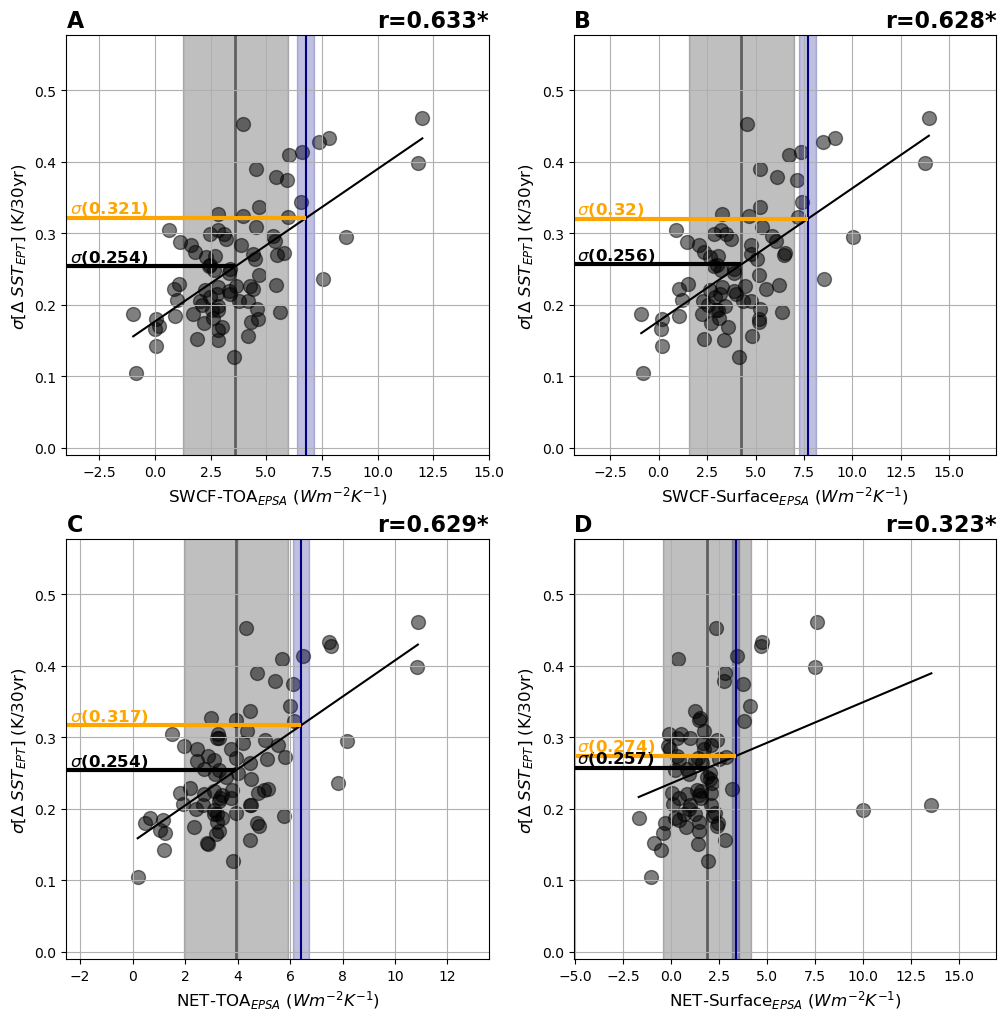

In [20]:
swcf_toa = {
   "cmip6": xr.open_dataarray("data/piControl/swcf_east_sa_cmip6_v3.nc"),
   "cmip5": xr.open_dataarray("data/piControl/swcf_east_sa_cmip5_v3.nc"),
    "obs": xr.open_dataset("data/obs/swcf_toa_epsa_obs.nc")
}

swcf_surface = {
   "cmip6": xr.open_dataarray("data/piControl/cf_east_sa_swcf-surface_cmip6_v3.nc"),
   "cmip5": xr.open_dataarray("data/piControl/cf_east_sa_swcf-surface_cmip5_v3.nc"),
    "obs": xr.open_dataset("data/obs/swcf_surface_epsa_obs.nc")
}

net_toa = {
   "cmip6": xr.open_dataarray("data/cloud_feedbacks_models/cf_east_sa_net-toa_cmip6_v3.nc"),
   "cmip5": xr.open_dataarray("data/cloud_feedbacks_models/cf_east_sa_net-toa_cmip5_v3.nc"),
    "obs": xr.open_dataset("data/obs/net_cf_toa_epsa_obs.nc")
}

net_surface = {
   "cmip6": xr.open_dataarray("data/cloud_feedbacks_models/cf_east_sa_net-surface_cmip6_v3.nc"),
   "cmip5": xr.open_dataarray("data/cloud_feedbacks_models/cf_east_sa_net-surface_cmip5_v3.nc"),
    "obs": xr.open_dataset("data/obs/net_cf_surface_epsa_obs.nc")
}

def compare_surface_toa(swcf_surface, swcf_toa, net_surface, net_toa):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    axis_fontsize = 12
    title_fontsize = 16
    
    # SWCF vs Variance of Trends 
    ax[0][0].grid()
    ax[0][0].set_xlabel(r"SWCF-TOA$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[0][0].set_ylabel(r"$\sigma$[$\Delta$ $SST_{EPT}$] (K/30yr)", fontsize=axis_fontsize) 
    ax[0][0].set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
    sig_mmm, sig_obs = create_panel_a(
        ax[0][0],
        swcf_toa["cmip6"].sortby("model").values, 
        sst_ept_cmip6.sortby("model").std("time").values, 
        swcf_toa["cmip5"].sortby("model").values, 
        sst_ept_cmip5.sortby("model").std("time").values, 
        vline=list(swcf_toa["obs"].values()) 
    )

    # SWCF vs Variance of Trends 
    ax[0][1].grid()
    ax[0][1].set_xlabel(r"SWCF-Surface$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[0][1].set_ylabel(r"$\sigma$[$\Delta$ $SST_{EPT}$] (K/30yr)", fontsize=axis_fontsize) 
    ax[0][1].set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
    swcf_surface6, sst_ept_6 = get_shared_models(swcf_surface["cmip6"], sst_ept_cmip6.std("time"))
    swcf_surface5, sst_ept_5 = get_shared_models(swcf_surface["cmip5"], sst_ept_cmip5.std("time"))
    sig_mmm, sig_obs = create_panel_a(
        ax[0][1],
        swcf_surface6.values, 
        sst_ept_6.values, 
        swcf_surface5.values, 
        sst_ept_5.values, 
        vline=list(swcf_surface["obs"].values()) 
    )

    # Net vs Variance of Trends 
    ax[1][1].grid()
    ax[1][1].set_xlabel(r"NET-Surface$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[1][1].set_ylabel(r"$\sigma$[$\Delta$ $SST_{EPT}$] (K/30yr)", fontsize=axis_fontsize) 
    ax[1][1].set_title("D", loc="left", fontweight="bold", fontsize=title_fontsize)
    net_surface6, sst_ept_6 = get_shared_models(net_surface["cmip6"], sst_ept_cmip6.std("time"))
    net_surface5, sst_ept_5 = get_shared_models(net_surface["cmip5"], sst_ept_cmip5.std("time"))
    sig_mmm, sig_obs = create_panel_a(
        ax[1][1],
        net_surface6.values, 
        sst_ept_6.values, 
        net_surface5.values, 
        sst_ept_5.values, 
        vline=list(net_surface["obs"].values()) 
    )
    
    # Net vs Variance of Trends 
    ax[1][0].grid()
    ax[1][0].set_xlabel(r"NET-TOA$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[1][0].set_ylabel(r"$\sigma$[$\Delta$ $SST_{EPT}$] (K/30yr)", fontsize=axis_fontsize) 
    ax[1][0].set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)
    net_toa6, sst_ept_6 = get_shared_models(net_toa["cmip6"], sst_ept_cmip6.std("time"))
    net_toa5, sst_ept_5 = get_shared_models(net_toa["cmip5"], sst_ept_cmip5.std("time"))
    sig_mmm, sig_obs = create_panel_a(
        ax[1][0],
        net_toa6.values, 
        sst_ept_6.values, 
        net_toa5.values, 
        sst_ept_5.values, 
        vline=list(net_toa["obs"].values()) 
    )
    plt.savefig("S4_CldFbks.png", dpi=600, bbox_inches="tight")

compare_surface_toa(swcf_toa=swcf_toa, swcf_surface=swcf_surface, net_toa=net_toa, net_surface=net_surface)

LinregressResult(slope=0.47562332676328956, intercept=3.060582017756631, rvalue=0.5628072941903525, pvalue=1.475101455859382e-07, stderr=0.08175817099478441, intercept_stderr=0.24251480624105987)
LinregressResult(slope=0.8788352461522652, intercept=-0.08889110847511761, rvalue=0.9985429737098827, pvalue=3.9773617967667724e-98, stderr=0.005447840068874338, intercept_stderr=0.027487049554898356)


ValueError: x and y must be the same size

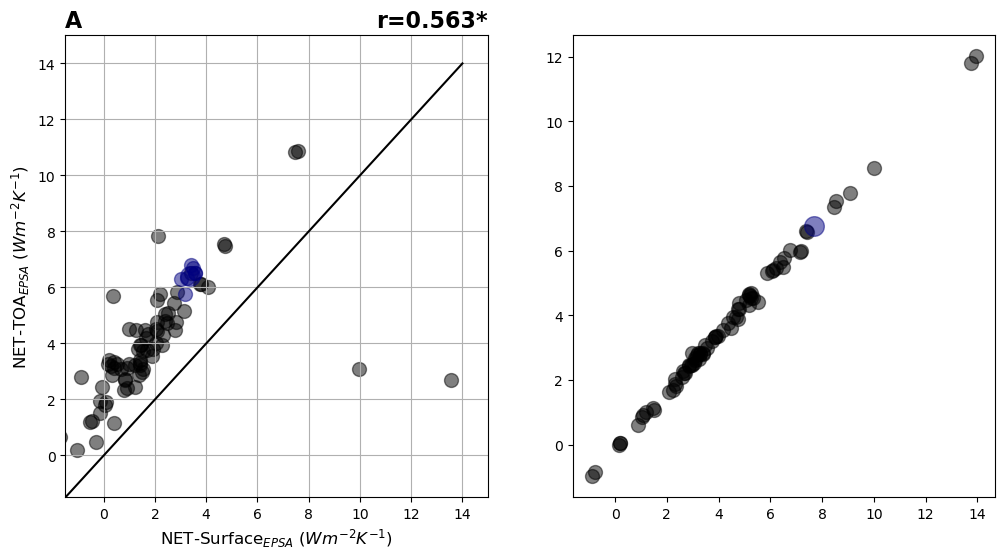

In [21]:
def scatter(ax, x, y, x_obs, y_obs) -> None:
    # Set the default color cycle
    colors = ['black','navy','#7570b3']

    ax.scatter(x, y, s=100, alpha=.5, edgecolor="black", color=colors[0])
    res = linregress(x, y)
    r = np.around(res.rvalue, 3)
    print(res)

    # Vertical line for avg and std of obs
    ax.scatter(np.mean(x_obs), np.mean(y_obs), s=200, alpha=.5, edgecolor="navy", color=colors[1])
    ax.scatter(x_obs, y_obs, s=100, alpha=.5, edgecolor="navy", color=colors[1])

    ax.plot(np.arange(-2, 15), np.arange(-2, 15), color="black")
    ax.set_ylim(-1.5, 15)
    ax.set_xlim(-1.5, 15)

    # Set Title
    ax.set_title(f"r={r}*", loc="right", fontweight="bold", fontsize=16)
    ax.grid()

def compare_surface_toa(swcf_surface, swcf_toa, net_surface, net_toa):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    axis_fontsize = 12
    title_fontsize = 16
    
    # NET Surface vs Net TOA 
    net_surface6, net_toa6 = get_shared_models(net_surface["cmip6"], net_toa["cmip6"])
    net_surface5, net_toa5 = get_shared_models(net_surface["cmip5"], net_toa["cmip5"])
    scatter(
        ax=ax[0],
        x=[*net_surface6.values, *net_surface5.values],
        y=[*net_toa6.values, *net_toa5.values], 
        x_obs=[*net_surface["obs"].values()],
        y_obs=[*net_toa["obs"].values()],
    )
    ax[0].set_title(f"A", loc="left", fontweight="bold", fontsize=16)
    axis_fontsize = 12
    ax[0].set_xlabel(r"NET-Surface$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[0].set_ylabel(r"NET-TOA$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)

    # SWCF-Surface vs SWCF-TOA
    swcf_surface6, swcf_toa6 = get_shared_models(swcf_surface["cmip6"], swcf_toa["cmip6"])
    swcf_surface5, swcf_toa5 = get_shared_models(swcf_surface["cmip5"], swcf_toa["cmip5"])
    scatter(
        ax=ax[1],
        x=[*swcf_surface6.values, *swcf_surface5.values],
        y=[*swcf_toa6.values, *swcf_toa5.values], 
        x_obs=[*swcf_surface["obs"].values()],
        y_obs=[*swcf_toa["obs"].values()],
    )
    ax[1].set_title(f"B", loc="left", fontweight="bold", fontsize=16)
    axis_fontsize = 12
    ax[1].set_xlabel(r"SWCF-Surface$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax[1].set_ylabel(r"SWCF-TOA$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    
    plt.savefig("S5_surfaceTOA.png", dpi=600, bbox_inches="tight")

compare_surface_toa(swcf_toa=swcf_toa, swcf_surface=swcf_surface, net_toa=net_toa, net_surface=net_surface)